<a href="https://colab.research.google.com/github/vicky30mar82/PyTorch/blob/main/CIFAR10_Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
from torchvision.transforms.transforms import ColorJitter

transform_train = transforms.Compose([transforms.Resize((32,32)),
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomRotation(10),
                               transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                               transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])

transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [6]:
classes = ('plane', 'car', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck',)

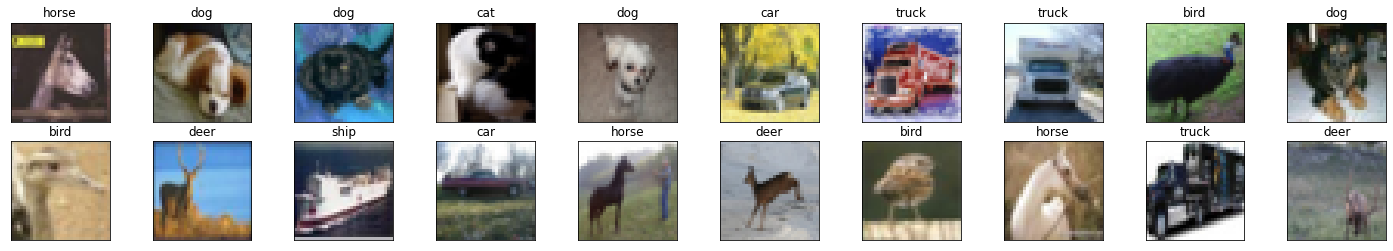

In [7]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [8]:
class LeNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
      self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)      
      self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
      self.fc1 = nn.Linear(4*4*64, 500)
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 4*4*64)
      x = F.relu(self.fc1(x))
      x = self.dropout1(x)
      x = self.fc2(x)
      return x

In [9]:
model = LeNet().cpu().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [11]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc.cpu())
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc.cpu())
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 1.5613, acc 42.2640 
validation loss: 1.3103, validation acc 52.9700 
epoch : 2
training loss: 1.2022, acc 56.7540 
validation loss: 1.1173, validation acc 60.3500 
epoch : 3
training loss: 1.0369, acc 63.0900 
validation loss: 1.0306, validation acc 63.9700 
epoch : 4
training loss: 0.9336, acc 66.8760 
validation loss: 0.9565, validation acc 66.2900 
epoch : 5
training loss: 0.8524, acc 70.1100 
validation loss: 0.8969, validation acc 68.6800 
epoch : 6
training loss: 0.7881, acc 72.3600 
validation loss: 0.8993, validation acc 69.0800 
epoch : 7
training loss: 0.7324, acc 73.9860 
validation loss: 0.8733, validation acc 70.3900 
epoch : 8
training loss: 0.6765, acc 76.0700 
validation loss: 0.8624, validation acc 70.6100 
epoch : 9
training loss: 0.6331, acc 77.5080 
validation loss: 0.8685, validation acc 71.4400 
epoch : 10
training loss: 0.5930, acc 78.9960 
validation loss: 0.8592, validation acc 71.2600 
epoch : 11
training loss: 0.5577, acc 80.1880 
va

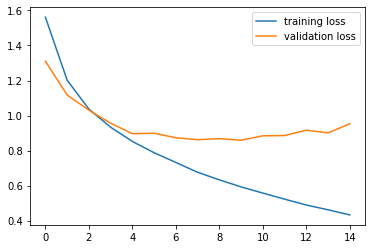

In [12]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

[tensor(42.2640), tensor(56.7540), tensor(63.0900), tensor(66.8760), tensor(70.1100), tensor(72.3600), tensor(73.9860), tensor(76.0700), tensor(77.5080), tensor(78.9960), tensor(80.1880), tensor(81.5600), tensor(82.4560), tensor(83.5540), tensor(84.5140)]
[tensor(52.9700), tensor(60.3500), tensor(63.9700), tensor(66.2900), tensor(68.6800), tensor(69.0800), tensor(70.3900), tensor(70.6100), tensor(71.4400), tensor(71.2600), tensor(71.4700), tensor(71.5600), tensor(72.1700), tensor(72.2700), tensor(72.1000)]


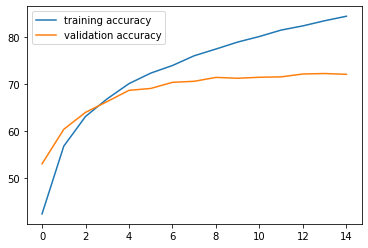

In [13]:
print(running_corrects_history)
print(val_running_corrects_history)
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [14]:
!pip3 install pillow==4.0.0

     |████████████████████████████████| 11.1 MB 4.6 MB/s 
     |████████████████████████████████| 112 kB 37.6 MB/s 
  Created wheel for pillow: filename=Pillow-4.0.0-cp37-cp37m-linux_x86_64.whl size=1007295 sha256=92aad124ea55efea82f4b104b7d9b366ee2378c07faf59e98af7536944a2c5be
  Stored in directory: /root/.cache/pip/wheels/ec/1e/24/dbc5e4964ea99cad93230a9013d934fb5adc322c3102f69e45
  Created wheel for olefile: filename=olefile-0.46-py2.py3-none-any.whl size=35432 sha256=1d42e55ddbe5ad3619b3636fd0c4d89a8f25b1199a7fce074d1b25d174bab4a2
  Stored in directory: /root/.cache/pip/wheels/84/53/e6/37d90ccb3ad1a3ca98d2b17107e9fda401a7c541ea1eb6a65a
Successfully built pillow olefile
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency co

In [15]:
import PIL.ImageOps

In [16]:
import requests 
from PIL import Image
url = 'https://c8.alamy.com/comp/DYC06A/hornless-reindeer-at-zoo-DYC06A.jpg'
response = requests.get(url, stream = True)
#print(response.raw)
img = Image.open(response.raw)
plt.imshow(img)


AttributeError: ignored

In [ ]:
img = transform(img)
plt.imshow(im_convert(img))

In [ ]:
img = img.view(img.shape[0], -1)
outputs = model(img)
_, preds = torch.max(outputs, 1)
print(preds.item())